In [1]:
import pandas as pd
import sqlite3 as sql

In [2]:
df=pd.read_csv("/content/weather.csv")

In [4]:
conn=sql.connect('weather_data.db')
cursor=conn.cursor()

cursor.execute("DROP TABLE IF EXISTS weather")

df.to_sql('weather',conn,index=False,if_exists='replace')

115

In [7]:
conn=sql.connect('weather_data.db')
city_info=pd.DataFrame(
    {
        'city':['London','Delhi','Newyork','Sydney','Johannesburg'],
        'Latitude':['51.5074','28.6139','40.7128','-33.8688','-26.2041'],
        'LONGITUDE':['-0.1278','77.2090','-74.0060','151.2093','28.0473']
    }
)
city_info.to_sql('city_info',conn,index=False,if_exists='replace')

5

In [13]:
query = """
SELECT city,temperature,humidity,timestamp
FROM weather w
JOIN city_info c
ON w.latitude = c.Latitude
AND w.longitude = c.LONGITUDE
"""
data = pd.read_sql_query(query, conn)
data

,city,temperature,humidity,timestamp
0,London,17.0,62.0,2025-08-02 06:33:09.114
1,London,17.0,62.0,2025-08-02 06:33:09.646
2,London,17.0,62.0,2025-08-02 07:00:11.969
3,London,17.0,62.0,2025-08-02 08:00:24.068
4,London,17.0,62.0,2025-08-02 10:17:45.005
...,...,...,...,...
110,Johannesburg,10.2,52.0,2025-08-01 15:00:11.225
111,Johannesburg,10.2,52.0,2025-08-01 19:25:50.271
112,Johannesburg,10.2,52.0,2025-08-01 20:00:09.373
113,Johannesburg,14.6,40.0,2025-08-02 06:33:06.701


In [14]:
conn=sql.connect('weather_data.db')
df.to_sql('data',conn,index=False,if_exists='replace')

115

#  Average Daily Temperature and Humidity by City

In [16]:
query='''SELECT c.city, AVG(w.temperature) AS avg_tmp, AVG(w.humidity) AS avg_hum
         FROM weather w
         JOIN city_info c ON w.latitude = c.Latitude AND w.longitude = c.LONGITUDE
         GROUP BY c.city
         ORDER BY avg_tmp, avg_hum
     '''

df1=pd.read_sql_query(query,conn)
display(df1)

,city,avg_tmp,avg_hum
0,Johannesburg,9.947826,59.478261
1,Sydney,10.821739,80.521739
2,London,17.447826,67.434783
3,Newyork,23.586957,59.695652
4,Delhi,27.773913,87.739130


<Axes: xlabel='city'>

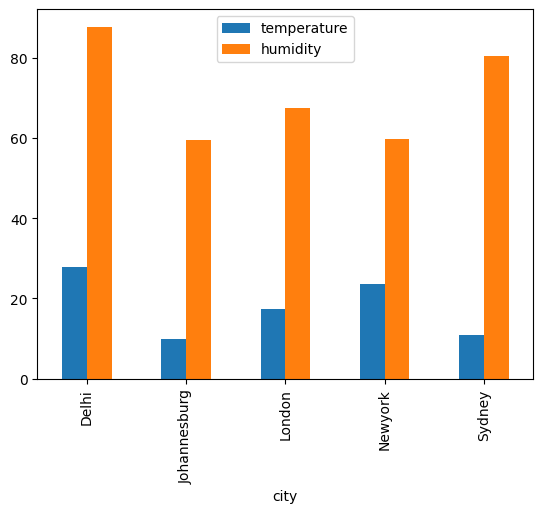

In [22]:
data.groupby('city')[['temperature','humidity']].mean().plot(kind='bar')

so we can see we are having higher average daily temperatures in delhi followed by sydney and London
and we are having higher humidity at Delhi and Newyork followed and eventhough we have noticed higher temperatures,the humitidy level is comparatively the least

# **Geographic Insights**

# Temperature/Humidity Range by City (Min/Max)

In [24]:
query='''select city,min(temperature) as min_tmp,max(temperature) as max_tmp,min(humidity) as min_hum,max(humidity) as max_hum,(max(temperature)-min(temperature)) as range_tmp,(max(humidity)-min(humidity)) as range_hum
         from weather w
         JOIN city_info c ON w.latitude = c.Latitude AND w.longitude = c.LONGITUDE
         GROUP BY c.city
     '''

df2=pd.read_sql_query(query,conn)
display(df2)

,city,min_tmp,max_tmp,min_hum,max_hum,range_tmp,range_hum
0,Delhi,26.3,34.7,45.0,94.0,8.4,49.0
1,Johannesburg,8.7,14.6,40.0,73.0,5.9,33.0
2,London,17.0,19.5,43.0,75.0,2.5,32.0
3,Newyork,23.4,23.9,58.0,61.0,0.5,3.0
4,Sydney,9.2,13.5,66.0,94.0,4.3,28.0


<Axes: xlabel='city'>

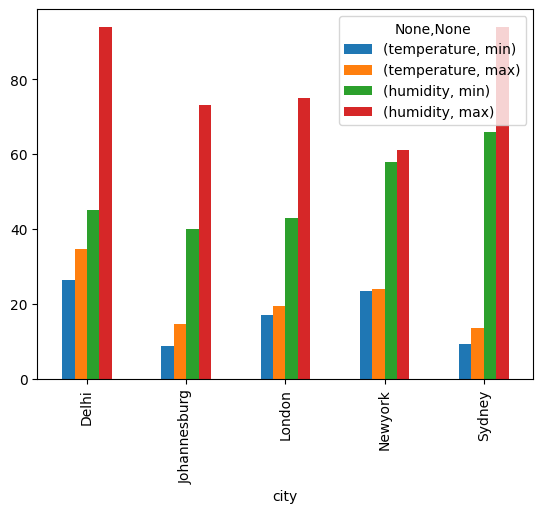

In [26]:
data.groupby('city')[['temperature','humidity']].agg(['min', 'max']).plot(kind='bar')

we can see the range of temperatures present in a day are highest and least in delhi and newyork respecitvely
and the range of humidity within a day is higher in delhi and lower in newyork again

# Standard Deviation for Variability

In [30]:
query='''select city,stddev(temperature) as std_tmp,stddev(humidity) as std_hum
        from weather w
        JOIN city_info c ON w.latitude = c.Latitude AND w.longitude = c.LONGITUDE
        GROUP BY c.city
     '''

df3=pd.read_sql_query(query,conn)
display(df3)


,temperature,humidity
city,,
Delhi,2.298857,13.618895
Johannesburg,1.633699,11.715838
London,0.565581,8.371087
Newyork,0.226243,1.019571
Sydney,1.970223,9.999407


<Axes: xlabel='city'>

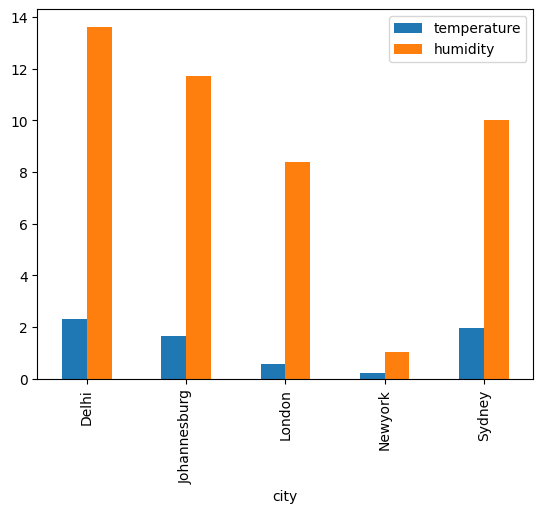

In [31]:
data.groupby('city')[['temperature','humidity']].std().plot(kind='bar')

so as we have seen above,correspondingly the temperatures and humidity levels in a day are spreaded over longer ranges in the delhi and over smaller ranges in the newyork around the mean

# **Time-Based Insights**

# Hourly Trends Across Cities


In [34]:
query='''select CAST(STRFTIME('%H', timestamp) AS INTEGER) as hour,avg(w.temperature) as avg_temp,avg(w.humidity) as avg_hum
         from weather w
         JOIN city_info c ON w.latitude = c.Latitude AND w.longitude = c.LONGITUDE
         GROUP BY hour
         order by hour
     '''

df4=pd.read_sql_query(query,conn)
display(df4)

,hour,avg_temp,avg_hum
0,6,18.286667,69.000000
1,7,17.360000,73.600000
2,8,17.370000,73.800000
3,10,17.400000,74.400000
4,11,17.360000,73.600000
5,13,17.340000,73.200000
6,14,18.160000,70.466667
7,15,18.170000,70.200000
8,16,18.140000,71.000000
9,19,18.690000,66.500000


the above results doesnt make so much sense because they have timestamps are present wrt london time,so we couldnt identify the trends properly within a day in other countries...though we can consider it as the average temperature of world is higher/lower at that particular time at london

# City with the Hottest or Most Humid Hour

In [50]:
query='''SELECT city, temperature,hour FROM (
           SELECT c.city, w.temperature,cast(strftime('%H',timestamp) as integer) as hour
           FROM weather w
           JOIN city_info c ON w.latitude = c.Latitude AND w.longitude = c.LONGITUDE
           ORDER BY w.temperature DESC
           LIMIT 1
         )
         UNION ALL
         SELECT city, humidity,hour FROM (
           SELECT c.city, w.humidity,cast(strftime('%H',timestamp) as integer) as hour
           FROM weather w
           JOIN city_info c ON w.latitude = c.Latitude AND w.longitude = c.LONGITUDE
           ORDER BY w.humidity DESC
           LIMIT 1
         )
     '''

df5=pd.read_sql_query(query,conn)
display(df5)

,city,temperature,hour
0,Delhi,34.7,19
1,Delhi,94.0,7


# **Trend and Pattern Insights**

#  Identify Peak Heat Hours Across All Cities

In [60]:
query='''
         select CAST(STRFTIME('%H', timestamp) AS INTEGER) as hour,avg(temperature) as avg_temp
         from weather
         group by hour
         order by avg_temp desc
         limit 5
     '''

df6=pd.read_sql_query(query,conn)
display(df6)

,hour,avg_temp
0,20,19.880000
1,19,18.690000
2,6,18.286667
3,15,18.170000
4,14,18.160000


In [65]:
data.groupby('timestamp').temperature.mean().sort_values(ascending=False)

,temperature
timestamp,
2025-08-01 19:25:51.137,34.7
2025-08-01 20:00:09.420,34.7
2025-08-02 06:33:09.558,27.8
2025-08-02 11:00:35.724,27.8
2025-08-02 07:00:12.280,27.8
...,...
2025-08-02 14:37:47.664,8.7
2025-08-02 14:37:53.265,8.7
2025-08-02 10:17:45.792,8.7


we can see that the average temperatures are higher when the time is in the range 19:00 -20:00 at London(as we are taking time of london as timestamps everywhere)

#  Correlation Proxy (Temp vs. Humidity)

In [61]:
query='''
         select temperature,avg(humidity)
         from weather
         group by temperature
         order by temperature

     '''

df7=pd.read_sql_query(query,conn)
display(df7)

,temperature,avg(humidity)
0,8.7,73.0
1,9.1,59.0
2,9.2,85.0
3,9.6,89.0
4,9.7,94.0
5,10.2,52.0
6,13.4,69.0
7,13.5,66.0
8,14.6,40.0
9,17.0,62.0


In [66]:
corr=df7.corr()
corr

,temperature,avg(humidity)
temperature,1.000000,-0.096904
avg(humidity),-0.096904,1.000000


<Axes: xlabel='temperature'>

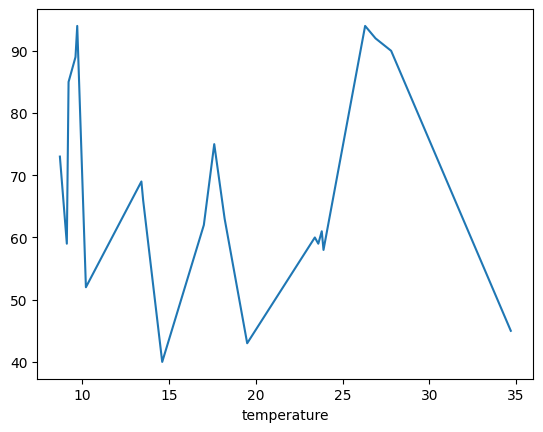

In [68]:
data.groupby('temperature').humidity.mean().plot()

so from the obtained data,there is no direct correlation between temperature and humidity as we can see humidity is fluctuating wrt temperature

# **Temporal Anomalies or Rapid Changes**

# Hours with Sharpest Temperature Changes

In [75]:
query='''
         SELECT city, timestamp,temperature - LAG(temperature) OVER (PARTITION BY city ORDER BY timestamp) AS temp_change
         FROM weather w
          JOIN city_info c ON w.latitude = c.Latitude AND w.longitude = c.LONGITUDE
          order by temp_change desc

     '''

df8=pd.read_sql_query(query,conn)
display(df8)

,city,timestamp,temp_change
0,Delhi,2025-08-01 19:25:51.137,8.4
1,Johannesburg,2025-08-02 06:33:06.701,4.4
2,Sydney,2025-08-01 14:00:11.912,4.3
3,Sydney,2025-08-02 14:37:55.813,3.8
4,London,2025-08-02 06:33:06.584,1.9
...,...,...,...
110,Delhi,2025-08-01 07:09:23.504,NaN
111,Johannesburg,2025-08-01 07:08:58.706,NaN
112,London,2025-08-01 07:08:41.707,NaN
113,Newyork,2025-08-01 07:09:36.231,NaN


we can see the sharpest temperature chane in delhi at 14:25:51 and followed by Johannesburg	at 06:33:06
	Sydney at	14:00:11(both in london time)

# Most Stable or Unstable City by Hourly Change

In [58]:
query='''
WITH diffs AS (
  SELECT city,
         temperature - LAG(temperature) OVER (PARTITION BY city ORDER BY timestamp) AS temp_diff
  FROM weather w
  JOIN city_info c ON w.latitude = c.Latitude AND w.longitude = c.LONGITUDE
)
SELECT city, AVG(ABS(temp_diff)) AS avg_temp_change
FROM diffs
GROUP BY city
ORDER BY avg_temp_change DESC;


     '''

df9=pd.read_sql_query(query,conn)
display(df9)

,city,avg_temp_change
0,Delhi,0.736364
1,Sydney,0.713636
2,Johannesburg,0.486364
3,London,0.254545
4,Newyork,0.036364
